In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab.patches import cv2_imshow

 # Étape 1 : Calcul des points SIFT sur les deux images (gauche et droite)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger les images
img_left = cv2.imread('/content/drive/MyDrive/Vision_par_ordinateur/TP1_CV_Descripteur_SIFT/Objets/thaprua.jpg', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('/content/drive/MyDrive/Vision_par_ordinateur/TP1_CV_Descripteur_SIFT/Image_Recherche/thaprua2.jpg', cv2.IMREAD_GRAYSCALE)

# Initialiser SIFT
sift = cv2.SIFT_create()

# Détecter les points d'intérêt et calculer les descripteurs
keypoints_left, descriptors_left = sift.detectAndCompute(img_left, None)
keypoints_right, descriptors_right = sift.detectAndCompute(img_right, None)



# Étape 2 : Mise en correspondance des points d’intérêt

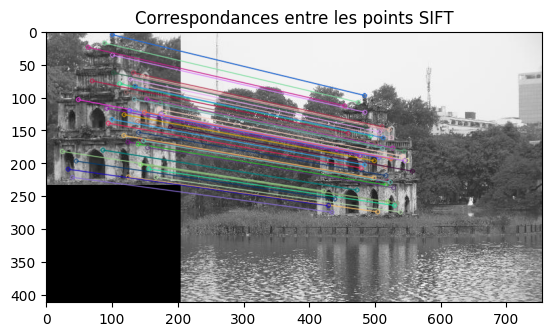

In [ ]:
# Utiliser BFMatcher pour trouver les correspondances
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors_left, descriptors_right)

# Trier les correspondances en fonction de la distance
matches = sorted(matches, key=lambda x: x.distance)

# Dessiner les correspondances
img_matches = cv2.drawMatches(img_left, keypoints_left, img_right, keypoints_right, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img_matches)
plt.title('Correspondances entre les points SIFT')
plt.show()

# Étape 3: Analyse de la qualité des correspondances

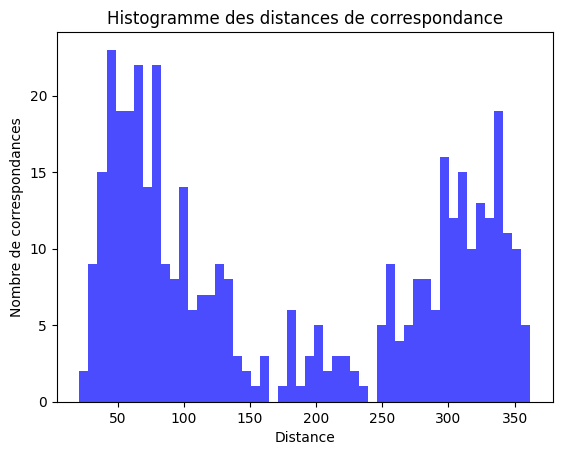

In [ ]:
# Calculer et afficher les distances des correspondances
distances = [match.distance for match in matches]
plt.hist(distances, bins=50, color='blue', alpha=0.7)
plt.title('Histogramme des distances de correspondance')
plt.xlabel('Distance')
plt.ylabel('Nombre de correspondances')
plt.show()

Meilleures et moins bonnes correspondances
Les meilleures correspondances se trouvent généralement dans les zones avec des textures distinctes et des caractéristiques uniques. Les moins bonnes se trouvent dans les zones uniformes ou avec peu de détails.

# Étape 4 : Carte de disparité

Nous avons déjà détecté et mis en correspondance les points d'intérêt entre les images gauche et droite, et que nous disposons des coordonnées des points correspondants dans chaque image. Nous allons utiliser la méthode de la somme des différences absolues (SAD) pour calculer la disparité entre chaque paire de points correspondants.

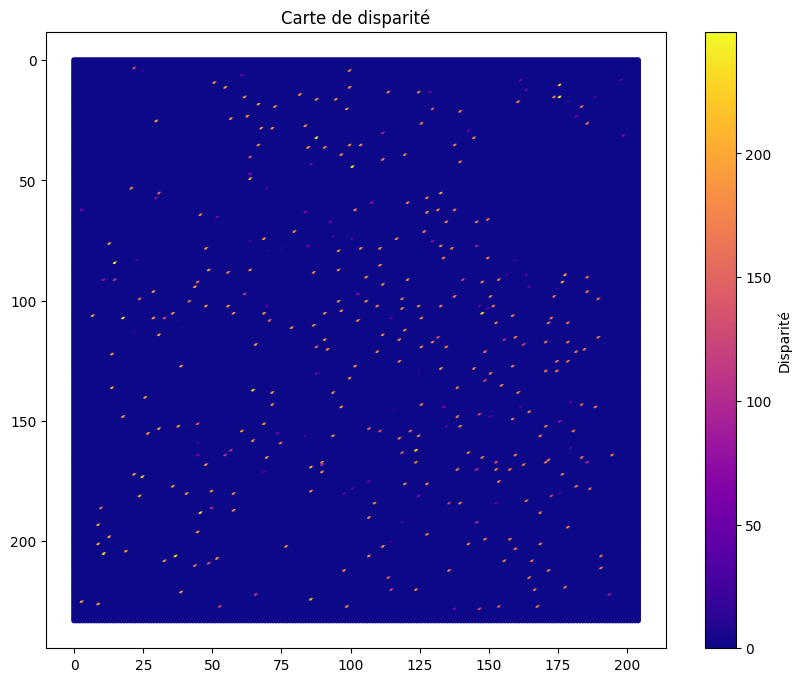

In [ ]:
# Affichage de la carte de disparité en couleur avec des points plus grands
plt.figure(figsize=(10, 8))  # Définition de la taille de la figure

# Création de la grille pour les coordonnées x et y
x_coords = np.arange(disparity_map.shape[1])
y_coords = np.arange(disparity_map.shape[0])
X, Y = np.meshgrid(x_coords, y_coords)

# Affichage des points de la carte de disparité en utilisant la fonction scatter
plt.scatter(X, Y, c=disparity_map, cmap='plasma', s=20, edgecolors='none')

# Configuration des axes et de la couleur
plt.title('Carte de disparité')
plt.colorbar(label='Disparité')
plt.gca().invert_yaxis()  # Inversion de l'axe y pour correspondre à l'orientation de l'image
plt.show()


# Étape 5 : Inversion des images gauche et droite

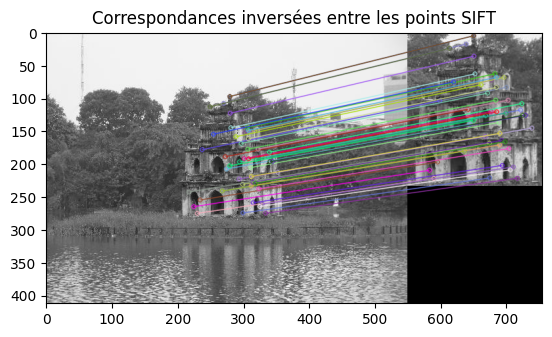

In [ ]:
# Inverser les images et répéter le processus
matches_inverted = bf.match(descriptors_right, descriptors_left)
matches_inverted = sorted(matches_inverted, key=lambda x: x.distance)

img_matches_inverted = cv2.drawMatches(img_right, keypoints_right, img_left, keypoints_left, matches_inverted[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img_matches_inverted)
plt.title('Correspondances inversées entre les points SIFT')
plt.show()

Analyse des résultats inversés
Visuellement : Les résultats peuvent sembler similaires, mais les directions des correspondances seront inversées.
Informations 3D : Les informations de profondeur peuvent être affectées par l'inversion, mais les correspondances principales devraient rester similaires.

# Étape 6 : Paramètres de la géométrie épipolaire
Il est possible de retrouver les paramètres de la géométrie épipolaire en utilisant les correspondances obtenues pour estimer la matrice fondamentale. Cette matrice peut ensuite être utilisée pour déterminer les épipoles et les lignes épipolaires.

## 6.1. Calcul de la matrice fondamentale

## 6.1.Estimation de la matrice fondamentale :
Nous utilisons les correspondances pour estimer la matrice fondamentale à l'aide de l'algorithme RANSAC (Random Sample Consensus). Cet algorithme permet d'identifier les correspondances les plus fiables en supprimant les valeurs aberrantes.

In [ ]:
# Calculer la matrice fondamentale
points_left = np.array([keypoints_left[m.queryIdx].pt for m in matches])
points_right = np.array([keypoints_right[m.trainIdx].pt for m in matches])

F, mask = cv2.findFundamentalMat(points_left, points_right, cv2.FM_RANSAC)

# Afficher la matrice fondamentale
print("Matrice fondamentale :")
print(F)



Matrice fondamentale :
[[ 1.84834804e-07  3.16572200e-06  1.25263030e-03]
 [-4.59031144e-06 -9.49417602e-07 -1.36850056e-02]
 [-5.00360855e-04  1.10039495e-02  1.00000000e+00]]


## 6.2.Calcul des épipoles
Une fois que nous avons la matrice fondamentale, nous pouvons utiliser ses propriétés pour calculer les épipoles dans les deux images.

In [ ]:
# Calcul des épipoles
epipole_left = cv2.computeCorrespondEpilines(np.array([[(0, 0)]]), 1, F)
epipole_right = cv2.computeCorrespondEpilines(np.array([[(0, 0)]]), 2, F)

# Affichage des épipoles
print("Epipole dans l'image de gauche :")
print(epipole_left)
print("Epipole dans l'image de droite :")
print(epipole_right)


Epipole dans l'image de gauche :
[[[ 0.091152 -0.995837 72.76848 ]]]
Epipole dans l'image de droite :
[[[-4.5424089e-02  9.9896777e-01  9.0782661e+01]]]


## 6.3.Calcul des lignes épipolaires
Les lignes épipolaires représentent les lignes sur lesquelles les épipoles se projettent dans chaque image.

In [ ]:
# Calcul des lignes épipolaires
lines_left = cv2.computeCorrespondEpilines(np.array([[(0, 0)]]), 2, F)
lines_right = cv2.computeCorrespondEpilines(np.array([[(0, 0)]]), 1, F)

# Affichage des lignes épipolaires
print("Lignes épipolaires dans l'image de gauche :")
print(lines_left)
print("Lignes épipolaires dans l'image de droite :")
print(lines_right)

Lignes épipolaires dans l'image de gauche :
[[[-4.5424089e-02  9.9896777e-01  9.0782661e+01]]]
Lignes épipolaires dans l'image de droite :
[[[ 0.091152 -0.995837 72.76848 ]]]
